# Traffic Sign Classifier in Neon

In [1]:
#Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import csv
import collections
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
import time
from datetime import timedelta
import math
import cv2
import matplotlib.gridspec as gridspec
import os
import random

In [2]:
# Load pickled data
TrainingFile = "../../traffic-signs-data/train.p"
TestingFile  = "../../traffic-signs-data/test.p"
LabelsFile   = "../../traffic-signs-data/signnames.csv"
with open(TrainingFile, mode='rb') as f:
    TrainingData = pickle.load(f)
with open(TestingFile, mode='rb') as f:
    TestingData = pickle.load(f)
with open(LabelsFile,mode='r') as csvfile:
    csvreader=csv.reader(csvfile)
    Labels=list(csvreader)
#Load into Arrays    
TrainFeatures, TrainLabels = TrainingData['features'], TrainingData['labels']
TestFeatures , TestLabels  = TestingData['features'] , TestingData['labels']

German Traffic Signs- Data Set Details
Number of training examples = 39209
Number of testing  examples = 12630
Number of classes           = 43
Max # of Signs              = 2250 with label Speed limit (50km/h)
Min # of Signs              = 210  with label Speed limit (20km/h)


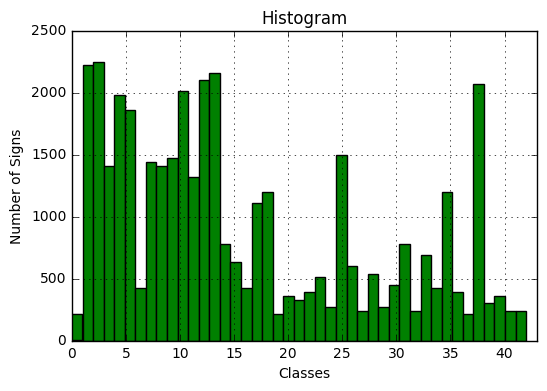

In [3]:
# Number of training,testing examples and classes
NumTrainSam = len(TrainFeatures)
NumTestSam  = len(TestFeatures)
NumClasses  = len(Labels)
#Data Exploration
#1. Count number of images in each class
ClassCount=collections.Counter(TrainLabels)
#2. Min and Max Signs
maxkey=max(ClassCount,key=ClassCount.get) # Index with max number of signs
minkey=min(ClassCount,key=ClassCount.get) # Index with min number of signs
maxnum=ClassCount[maxkey]
minnum=ClassCount[minkey]
#Convert to list. ClassList has number of images for each class
ClassList=[]
for key, values in ClassCount.items():
    ClassList.append(values)
#Print the details
print("German Traffic Signs- Data Set Details")
print("Number of training examples =", NumTrainSam)
print("Number of testing  examples =", NumTestSam)
print("Number of classes           =", NumClasses)
print("Max # of Signs              = "+str(maxnum)+" with label "+str(Labels[maxkey][1]))
print("Min # of Signs              = "+str(minnum)+"  with label "+str(Labels[minkey][1]))

#Plot the histogram
plt.figure()
plt.title('Histogram')
plt.xlabel('Classes')
plt.ylabel('Number of Signs')
plt.grid(True)
plt.axis([0,NumClasses,0,2500])
n, bins, patches = plt.hist(TrainLabels, NumClasses ,facecolor='green')


In [4]:
#Calculate data that needs to be generated and store it in ToGenNum list
ToGenNum=[]
#Print all classes
print("\n{:<55}{:<10}{:>20}".format("Traffic Sign","In Dataset","To be Generated"))
for i in range(0,NumClasses):
    String=str("{:<55}".format(Labels[i][1]))+"{:<10}".format(str(ClassList[i]))\
    +"{:>20}".format(str(maxnum-ClassList[i]))
    print(String)
    ToGenNum.append(maxnum-ClassList[i])

TotalNewData2Gen=sum(ToGenNum)
TotalDataSize=NumTrainSam+TotalNewData2Gen
print("\nTotal Data to be generated: "+str(TotalNewData2Gen))
print("Size of Total Dataset after new data is generated: "+str(TotalDataSize))


Traffic Sign                                           In Dataset     To be Generated
Speed limit (20km/h)                                   210                       2040
Speed limit (30km/h)                                   2220                        30
Speed limit (50km/h)                                   2250                         0
Speed limit (60km/h)                                   1410                       840
Speed limit (70km/h)                                   1980                       270
Speed limit (80km/h)                                   1860                       390
End of speed limit (80km/h)                            420                       1830
Speed limit (100km/h)                                  1440                       810
Speed limit (120km/h)                                  1410                       840
No passing                                             1470                       780
No passing for vechiles over 3.5 metric tons         

In [5]:
#Idea is to generate same random numbers so we can compare results after preprocessing
RandState=random.getstate() #Store randstate to get same results everytime

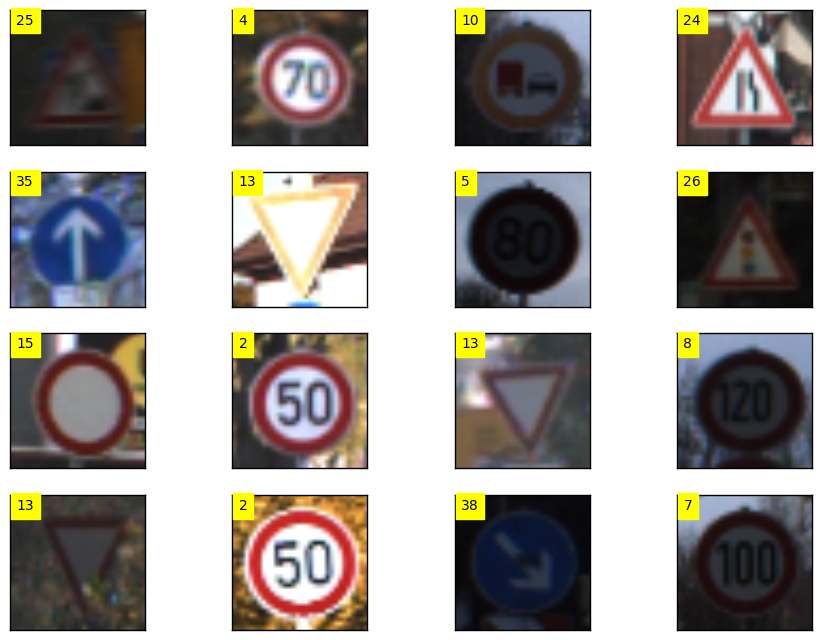

In [6]:
#Plot Random Images. 
def pltRandImages(ImgArray,ImgLabels,Rows=2):
    plt.figure(figsize=(11,8))
    pltIndex=0;
    ImgIndex=0;
    gs=gridspec.GridSpec(Rows,Rows)
    random.setstate(RandState)
    ImgIndex=random.sample(range(len(ImgArray)),Rows*Rows)
    for i in range (0,Rows*Rows):
        if(pltIndex>Rows-1):
            pltIndex=0
        ax=plt.subplot(gs[int(i/Rows),pltIndex])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.text(1,3,str(ImgLabels[ImgIndex[i]]),backgroundcolor='yellow')
        plt.imshow(ImgArray[ImgIndex[i]])
        pltIndex=pltIndex+1
pltRandImages(TrainFeatures,TrainLabels,4)

###  Augmenting Training Data


In [7]:
GenShape=(TotalNewData2Gen,32,32,3) #Shape of array to hold generated data
TrainFeaturesGen=np.zeros(GenShape,TrainFeatures.dtype)     #Array to hold generated images
TrainLabelsGen=np.zeros(TotalNewData2Gen,TrainLabels.dtype) #Array to hold generated labels

# Generate to be generated number of random index from each class
RandImgIndex=[]
Count=0
for i in range(0,NumClasses):
    RandImgIndex.append(np.random.randint(Count,Count+ClassList[i],ToGenNum[i]))
    Count=Count+ClassList[i]

#Generating Augmented Data by Rotating, Scaling and Changing Positions
#Values are from [1]
IndexCount=0
for i in range(0,NumClasses):
    print("Generating "+str(ToGenNum[i])+" "+str(Labels[i][1])+" features and labels")
    for j in range(0,ToGenNum[i]):
        Image=TrainFeatures[RandImgIndex[i][j]]
        #Rotation
        MaxRotAngle=15
        rows,cols,chnls=Image.shape
        RotMatrix=cv2.getRotationMatrix2D((rows/2,cols/2),random.uniform(-MaxRotAngle,MaxRotAngle),1)
        Image=cv2.warpAffine(Image,RotMatrix,(rows,cols))
        #Translation
        TransMatrix=np.float32([[1,0,random.uniform(-2,2)],[0,1,random.uniform(-2,2)]])
        Image=cv2.warpAffine(Image,TransMatrix,(rows,cols))
        #Scale
        #Image=cv2.resize(Image,None,fx=random.uniform(0.9,1.1),fy=random.uniform(0.9,1.1),interpolation=cv2.INTER_CUBIC)
        TrainFeaturesGen[IndexCount]=Image
        TrainLabelsGen[IndexCount]=i
        IndexCount=IndexCount+1
#Booleans to prevent doing accumulation or pre processing being done multiple times
DataAccDone=False    #Data Accumulation Done
PreProcessDone=False #Pre Processing Done
ValSplitDone=False

Generating 2040 Speed limit (20km/h) features and labels
Generating 30 Speed limit (30km/h) features and labels
Generating 0 Speed limit (50km/h) features and labels
Generating 840 Speed limit (60km/h) features and labels
Generating 270 Speed limit (70km/h) features and labels
Generating 390 Speed limit (80km/h) features and labels
Generating 1830 End of speed limit (80km/h) features and labels
Generating 810 Speed limit (100km/h) features and labels
Generating 840 Speed limit (120km/h) features and labels
Generating 780 No passing features and labels
Generating 240 No passing for vechiles over 3.5 metric tons features and labels
Generating 930 Right-of-way at the next intersection features and labels
Generating 150 Priority road features and labels
Generating 90 Yield features and labels
Generating 1470 Stop features and labels
Generating 1620 No vechiles features and labels
Generating 1830 Vechiles over 3.5 metric tons prohibited features and labels
Generating 1140 No entry features 

Data Accumulation Started
Data Accumulation Done


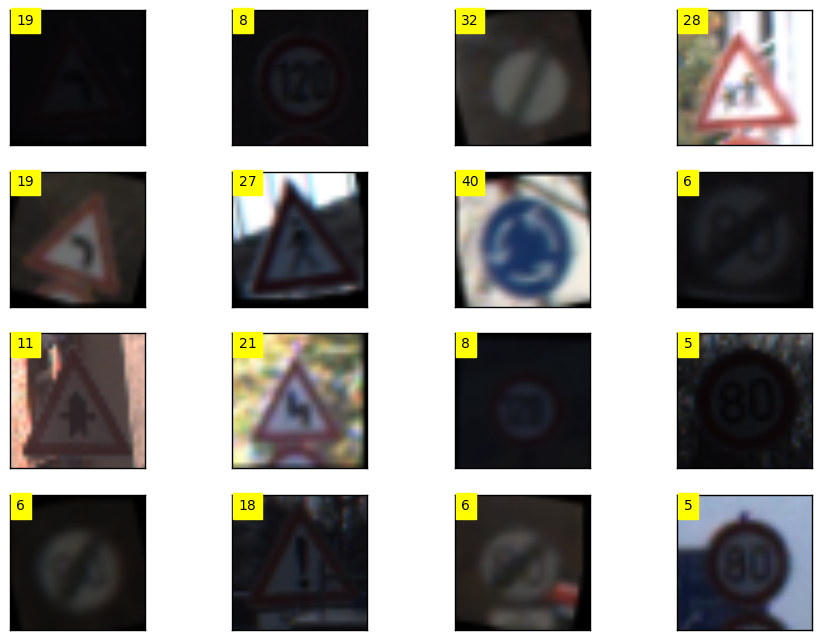

In [8]:
#Accumulating Generated Data with Original Data
if(DataAccDone==False):
    print("Data Accumulation Started")
    TrainFeatures=np.append(TrainFeatures,TrainFeaturesGen,axis=0)
    TrainLabels=np.append(TrainLabels,TrainLabelsGen)
    DataAccDone=True
    print("Data Accumulation Done")
assert(TrainFeatures.shape[0]==TotalDataSize)
pltRandImages(TrainFeatures,TrainLabels,4)

### Pre Processing Data

In [9]:
#Pre Processing all the Images now
Channels=1
def preProcess(Img):
    Image=Img
    if(Channels==3):
        #Global Histogram Equilization
        Image[:,:,0]=cv2.equalizeHist(Image[:,:,0])
        Image[:,:,1]=cv2.equalizeHist(Image[:,:,1])
        Image[:,:,2]=cv2.equalizeHist(Image[:,:,2])
        #Local Histogram Equilization
        clahe=cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        Image[:,:,0]=clahe.apply(Image[:,:,0])
        Image[:,:,1]=clahe.apply(Image[:,:,1])
        Image[:,:,2]=clahe.apply(Image[:,:,2])
    if(Channels==1):
        #Convert to GreyScale
        Image=cv2.cvtColor(Image,cv2.COLOR_BGR2GRAY)
        #Global Histogram Equilization
        Image=cv2.equalizeHist(Image)
        #Local Histogram Equilization
        clahe=cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        Image=clahe.apply(Image)        
    return Image
#Pre Processing Training Image
if(PreProcessDone==False):
    print("Pre Processing Data Started")
    if(Channels==3):
        TrainFeaturesPP=np.zeros(shape=[TotalDataSize,32,32,Channels],dtype=TrainFeatures.dtype)
        TestFeaturesPP=np.zeros(shape=[TestFeatures.shape[0],32,32,Channels],dtype=TrainFeatures.dtype)
    if(Channels==1):
        TrainFeaturesPP=np.zeros(shape=[TotalDataSize,32,32],dtype=TrainFeatures.dtype)
        TestFeaturesPP=np.zeros(shape=[TestFeatures.shape[0],32,32],dtype=TrainFeatures.dtype)
    for i in range(0,len(TrainFeatures)):
        TrainFeaturesPP[i]=preProcess(TrainFeatures[i])
    for i in range(0,len(TestFeatures)):
        TestFeaturesPP[i]=preProcess(TestFeatures[i])
    PreProcessDone=True
    print("Pre Processing Done")


Pre Processing Data Started
Pre Processing Done


In [10]:
#Splitting into Train and Validation Sets
ValSize=0.25 #25%
if(ValSplitDone==False):
    TrainFeaturesPP, ValFeaturesPP, TrainLabels, ValLabels = train_test_split(
     TrainFeaturesPP,TrainLabels, test_size=ValSize, random_state=2)
    ValSplitDone=True
assert((ValFeaturesPP.shape[0]+TrainFeaturesPP.shape[0])==TotalDataSize)

### Neural Network

In [27]:
#Setup Backend to GPU
from neon.backends import gen_backend
BackEnd=gen_backend(backend='gpu',batch_size=1024)

In [28]:
#Reshape features to work with neon
ReshapeVal=32*32*Channels
#Empty Arrays
TrainFeaturesReshaped=np.zeros(shape=[TrainFeaturesPP.shape[0],ReshapeVal],
                               dtype=TrainFeatures.dtype)
ValFeaturesReshaped=np.zeros(shape=[ValFeaturesPP.shape[0],ReshapeVal],
                               dtype=TrainFeatures.dtype)
TestFeaturesReshaped=np.zeros(shape=[TestFeaturesPP.shape[0],ReshapeVal],
                               dtype=TrainFeatures.dtype)
#Reshaping Features
TrainFeaturesReshaped=TrainFeaturesPP.reshape(-1,ReshapeVal)
TestFeaturesReshaped=TestFeaturesPP.reshape(-1,ReshapeVal)
ValFeaturesReshaped=ValFeaturesPP.reshape(-1,ReshapeVal)
#Label Reshape
TrainLabelsReshaped=TrainLabels.reshape(-1,1)
TestLabelsReshaped=TestLabels.reshape(-1,1)
ValLabelsReshaped=ValLabels.reshape(-1,1)


In [29]:
from neon.data import ArrayIterator
TrainIter=ArrayIterator(TrainFeaturesReshaped,TrainLabelsReshaped,NumClasses,lshape=(Channels,32,32))
ValidIter=ArrayIterator(ValFeaturesReshaped,ValLabelsReshaped,NumClasses,lshape=(Channels,32,32))
TestIter=ArrayIterator(TestFeaturesReshaped,TestLabelsReshaped,NumClasses,lshape=(Channels,32,32))

In [30]:
from neon.layers import Conv,Affine,Pooling,LRN,Dropout
from neon.initializers import Xavier
from neon.transforms.activation import Rectlin,Softmax
#Filter,Fully Connected and Dropout probability Parameters
FilterSize=[5,3,3,3]
NumFilters=[16,64,64,64]
FCSize=[1024,1024,256,128]
KeepProb=0.5
#Weight initialization
WeightInit=Xavier()
#Network Layers
NetworkLayers=[Conv(fshape=(FilterSize[0],FilterSize[0],NumFilters[0]),
                   init=WeightInit,activation=Rectlin()),
               Pooling(fshape=1,strides=2),
               LRN(depth=5,ascale=2e-05,bpower=0.75),
               
               Conv(fshape=(FilterSize[1],FilterSize[1],NumFilters[1]),
                   init=WeightInit,activation=Rectlin()),
               Pooling(fshape=1,strides=2),
               LRN(depth=5,ascale=2e-05,bpower=0.75),
               
               Conv(fshape=(FilterSize[2],FilterSize[2],NumFilters[2]),
                   init=WeightInit,activation=Rectlin()),
               #Pooling(fshape=1,strides=2),
               LRN(depth=5,ascale=2e-05,bpower=0.75),
               
               Conv(fshape=(FilterSize[3],FilterSize[3],NumFilters[3]),
                   init=WeightInit,activation=Rectlin()),
               
               Affine(nout=FCSize[0],init=WeightInit,activation=Rectlin()),
               Dropout(keep=KeepProb),
               Affine(nout=FCSize[1],init=WeightInit,activation=Rectlin()),
               Dropout(keep=KeepProb),
               Affine(nout=FCSize[2],init=WeightInit,activation=Rectlin()),
               Dropout(keep=KeepProb),
               Affine(nout=FCSize[3],init=WeightInit,activation=Rectlin()),
               Affine(nout=NumClasses,init=WeightInit,activation=Softmax())               
              ]


In [31]:
#Model
from neon.models import Model
MyNwModel=Model(NetworkLayers)

In [32]:
#Cost Function and optimizer
from neon.layers import GeneralizedCost
from neon.transforms import CrossEntropyMulti
from neon.optimizers import Adam
Cost=GeneralizedCost(CrossEntropyMulti())
Optimizer=Adam(learning_rate=1e-3,beta_1=0.9, beta_2=0.999)


In [33]:
#Callbacks
from neon.callbacks.callbacks import Callbacks
callbacks=Callbacks(MyNwModel,ValidIter)

In [34]:
#Training the model

MyNwModel.fit(dataset=TrainIter,cost=Cost,optimizer=Optimizer,num_epochs=50,
              callbacks=callbacks)

Epoch 0   [Train |████████████████████|   71/71   batches, 3.71 cost, 0.82s]
Epoch 1   [Train |████████████████████|   71/71   batches, 3.48 cost, 0.69s]
Epoch 2   [Train |████████████████████|   71/71   batches, 3.32 cost, 0.88s]
Epoch 3   [Train |████████████████████|   71/71   batches, 3.16 cost, 0.72s]
Epoch 4   [Train |████████████████████|   71/71   batches, 2.96 cost, 0.68s]
Epoch 5   [Train |████████████████████|   71/71   batches, 2.68 cost, 0.82s]
Epoch 6   [Train |████████████████████|   71/71   batches, 2.43 cost, 0.74s]
Epoch 7   [Train |████████████████████|   70/70   batches, 2.17 cost, 0.68s]
Epoch 8   [Train |████████████████████|   71/71   batches, 1.79 cost, 0.68s]
Epoch 9   [Train |████████████████████|   71/71   batches, 1.47 cost, 0.69s]
Epoch 10  [Train |████████████████████|   71/71   batches, 1.26 cost, 0.68s]
Epoch 11  [Train |████████████████████|   71/71   batches, 1.12 cost, 0.84s]
Epoch 12  [Train |████████████████████|   71/71   batches, 0.98 cost, 0.70s]

In [35]:
from neon.transforms import Accuracy
print ("Validation Accuracy - ",100* MyNwModel.eval(ValidIter,metric=Accuracy()))
print ("Test       Accuracy - ",100* MyNwModel.eval(TestIter,metric=Accuracy()))


Validation Accuracy -  [ 95.70861816]
Test       Accuracy -  [ 93.84797668]


In [36]:
#Function to classify image and show top 5 probabilities
def ClassifyImg(ImgName):
    #Resize Dimenstions
    dim=(32,32)
    #Read Image
    Image=cv2.imread(ImgName)
    Image1=Image
    #Resize Image
    Image=cv2.resize(Image,dim,cv2.INTER_CUBIC)
    #PreProcess Image
    Image=preProcess(Image)
    #Do prediction for the image
    from neon.data import ArrayIterator
    x_new=np.zeros((1024,1024),dtype=np.float32)
    x_new[0]=Image.reshape(1,1024)
    Inference_Result=ArrayIterator(x_new,None,nclass=NumClasses,lshape=(1,32,32))
    out=MyNwModel.get_outputs(Inference_Result)
    #Get Top 5 result indexes in descending order
    Top5=(np.argsort(-out[0]))
    Top5=Top5.tolist()
    Top5=Top5[0:5]
    Top5Prob=[]
    for i in range(0,5):
        Top5Prob.append(out[0][Top5[i]])
    Top5Prob.reverse()
    fig=plt.figure()
    ax1=fig.add_subplot(121)
    ax1.imshow(cv2.cvtColor(Image1,cv2.COLOR_BGR2RGB))
    plt.title("Predicted: "+' '.join(Labels[int(Top5[0])]))
    ax1.set_xticks([])
    ax1.set_yticks([])
    #Plot the predictions
    ax2=fig.add_subplot(122)
    ax2.barh(np.arange(5),Top5Prob,color='green',ecolor='black')
    for i in range(0,5):
        ax2.text(0.05,(0.85-(i/5)),Labels[Top5[i]],transform=ax2.transAxes)
    ax2.set_xticks([])
    ax2.set_yticks([])


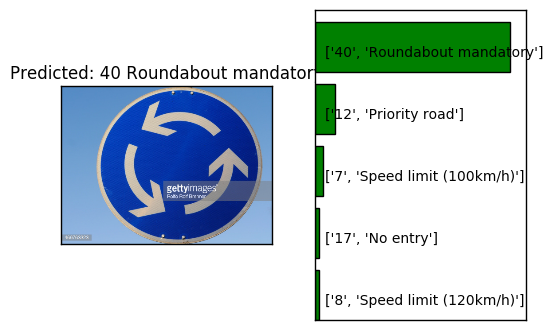

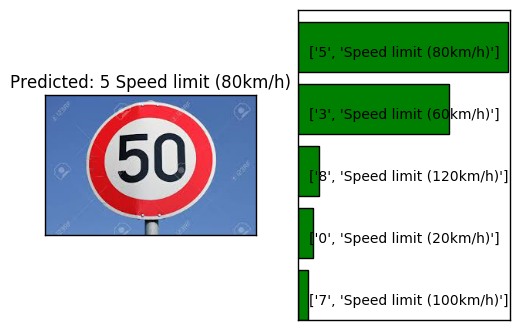

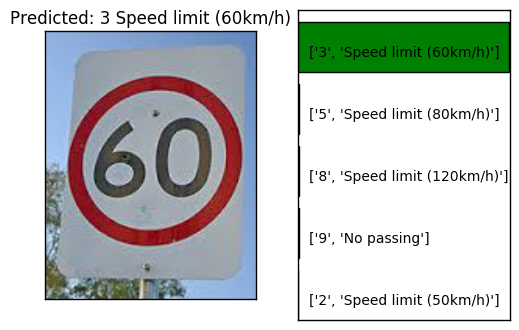

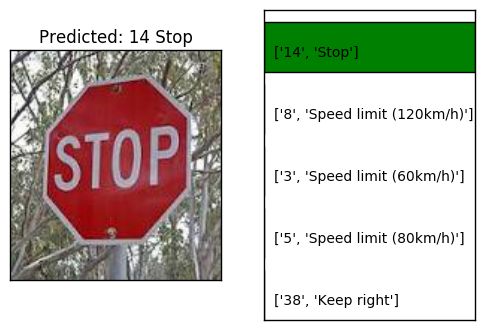

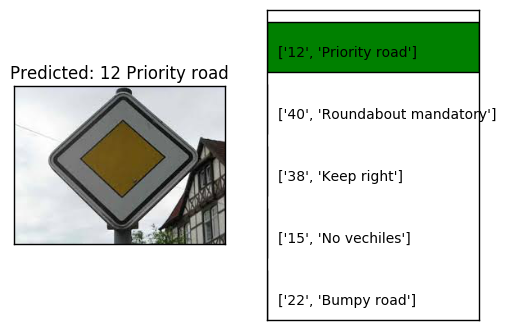

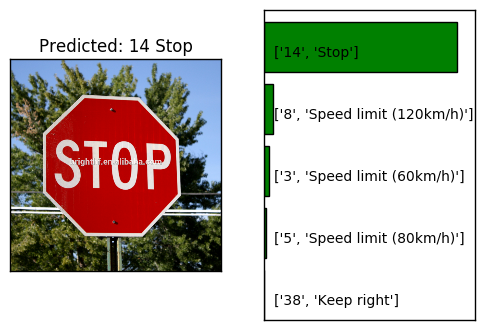

In [37]:
ClassifyImg("G0_Round.jpg")
ClassifyImg("G1_50mph.jpg")
ClassifyImg("G2_60mph.jpg")
ClassifyImg("G3_Stop1.jpg")
ClassifyImg("G4_PRoad.jpg")
ClassifyImg("G6_Stop.png")